<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [150]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

Hagamos lo pedido. Creemos dos dataframe inmediatamente, uno con las variables numéricas y otro con las variables categóricas. Veamos que tipos de datos hay primero y hagamos el filtro deseado.

In [151]:
df.dtypes

,0
year,int64
desplazamiento,float64
cilindros,float64
co2,float64
clase_tipo,object
traccion_tipo,object
transmision_tipo,object
combustible_tipo,object
tamano_motor_tipo,object
consumo_tipo,object


In [152]:
num_cols=df.select_dtypes(include=['int64','float64']).columns
obj_cols=df.select_dtypes(include=['object']).columns

df_num=df[num_cols].copy()
df_obj=df[obj_cols].copy()

Veamos si hay datos vacíos en las columnas numéricas.

In [153]:
df_num.isna().sum()

,0
year,0
desplazamiento,2
cilindros,3
co2,0
consumo_litros_milla,0


In [154]:
df_num[df_num['desplazamiento'].isna()==True]

,year,desplazamiento,cilindros,co2,consumo_litros_milla
32352,1985,NaN,NaN,370.291667,0.157725
32353,1985,NaN,NaN,386.391304,0.164583


Rellenemos los datos vacíos de los datos numéricos con el promedio asociado a cada columna.

In [155]:
mean=df_num.mean()
df_num.fillna(value=mean, inplace=True)

mean

,0
year,2000.787421
desplazamiento,3.321786
cilindros,5.746493
co2,473.185008
consumo_litros_milla,0.201134


In [156]:
df_num.iloc[32352]

,32352
year,1985.000000
desplazamiento,3.321786
cilindros,5.746493
co2,370.291667
consumo_litros_milla,0.157725


Podemos ver que realizamos lo pedido. Usemos ahora el `MinMaxScaler` de `sklearn` para normalizar los datos.

In [157]:
df_num_scaled=pd.DataFrame(data=MinMaxScaler().fit_transform(df_num),columns=num_cols)
df_num_scaled.head()

,year,desplazamiento,cilindros,co2,consumo_litros_milla
0,0.000000,0.243590,0.142857,0.398014,0.331027
1,0.000000,0.461538,0.285714,0.527672,0.475113
2,0.029412,0.243590,0.142857,0.424351,0.360294
3,0.029412,0.461538,0.285714,0.527672,0.475113
4,0.088235,0.410256,0.285714,0.424351,0.360294


Ahora, tratemos los datos categóricos y transformemos cada columna categórica en ceros y unos para tratarlo facilmente.

In [158]:
df_obj_dummies=pd.get_dummies(df_obj,dtype='int')
df_obj_dummies.head()

,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,clase_tipo_Deportivos,clase_tipo_Furgoneta,clase_tipo_Vehículos Especiales,traccion_tipo_cuatro,traccion_tipo_dos,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


Finalmente, juntemos ambos de estos dataframe en uno para tener todo organizado y preparado para trabajar en las siguientes partes.

In [159]:
df_new=pd.concat([df_num_scaled,df_obj_dummies],axis=1)
df_new.head()

,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.000000,0.243590,0.142857,0.398014,0.331027,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0.000000,0.461538,0.285714,0.527672,0.475113,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.029412,0.243590,0.142857,0.424351,0.360294,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0.029412,0.461538,0.285714,0.527672,0.475113,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.088235,0.410256,0.285714,0.424351,0.360294,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0


### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

Ajustemos el modelo `kmeans` con 8 clusters.

In [160]:
X=np.array(df_new)
k_means=KMeans(n_clusters=8,n_init=10,random_state=1)
k_means.fit(X)

KMeans(n_init=10, random_state=1)

Calculemos el valor de los centroides en cada cluster, y coloquemos los resultados en un dataframe.

In [161]:
df_centroids=pd.DataFrame(data=k_means.cluster_centers_,columns=df_new.columns)
df_centroids['cluster']=[1,2,3,4,5,6,7,8]

df_centroids

,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo,cluster
0,0.409097,0.333875,0.258094,0.354202,0.281296,1.784735e-01,0.083912,0.093594,0.135711,0.181862,...,3.162821e-02,9.630466e-01,1.613684e-04,5.163789e-03,1.452316e-03,6.454736e-04,9.979022e-01,-4.218847e-15,4.718448e-16,1
1,0.524300,0.250770,0.195525,0.304420,0.226575,6.228750e-02,0.095063,0.045696,0.153543,0.448524,...,9.768802e-01,-2.653433e-14,-9.936496e-15,2.311982e-02,-9.020562e-15,9.922481e-01,6.391949e-03,7.882583e-15,1.359989e-03,2
2,0.286204,0.542296,0.405019,0.511295,0.453191,5.357357e-01,0.001802,0.000601,0.015616,0.221021,...,-1.249001e-15,1.321321e-02,9.381381e-01,-5.717649e-15,-2.303713e-15,7.494005e-16,-3.941292e-15,1.000000e+00,-3.858025e-15,3
3,0.478350,0.451011,0.327420,0.410011,0.343304,3.050522e-01,0.017054,0.041356,0.048391,0.150288,...,-1.421085e-14,4.050309e-02,8.526967e-04,-6.550316e-15,9.921126e-01,6.395225e-04,6.395225e-04,6.608399e-03,-1.768030e-14,4
4,0.438404,0.159576,0.141184,0.242287,0.156504,1.640712e-02,0.124861,0.006396,0.092881,0.709956,...,-1.204592e-14,1.709743e-14,1.257328e-14,1.000000e+00,9.658940e-15,2.780868e-03,1.390434e-03,-7.133183e-15,9.958287e-01,5
5,0.588065,0.362121,0.299467,0.354068,0.282213,1.512097e-03,0.083921,0.086442,0.190020,0.561240,...,2.746976e-02,9.720262e-01,1.354472e-14,-6.467049e-15,2.318548e-02,7.494005e-16,9.768145e-01,-1.026956e-14,-1.632028e-14,6
6,0.695702,0.179404,0.150728,0.240178,0.156814,1.135203e-14,0.110189,0.027742,0.181747,0.546539,...,-1.265654e-14,2.592689e-04,1.326717e-14,9.997407e-01,1.065814e-14,1.737101e-02,5.185377e-04,-9.381385e-15,9.821104e-01,7
7,0.450473,0.586358,0.424741,0.505552,0.448533,2.721449e-01,0.004392,0.046303,0.045571,0.113653,...,-1.521006e-14,7.869693e-03,9.540630e-01,-6.633583e-15,1.281113e-03,-6.716849e-15,1.830161e-04,9.985359e-01,-1.132427e-14,8


Asignemos a cada dato su respectivo cluster en el dataframe original.

In [162]:
df_new['cluster']=k_means.labels_

df_new.head()

,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo,cluster
0,0.000000,0.243590,0.142857,0.398014,0.331027,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
1,0.000000,0.461538,0.285714,0.527672,0.475113,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,7
2,0.029412,0.243590,0.142857,0.424351,0.360294,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
3,0.029412,0.461538,0.285714,0.527672,0.475113,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,7
4,0.088235,0.410256,0.285714,0.424351,0.360294,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,3


Creemos otro dataframe que tenga el promedio de cada una de las variables numericas para cada cluster.

In [163]:
df_mean=df_new.groupby('cluster').mean()
df_mean

,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.409097,0.333875,0.258094,0.354202,0.281296,0.178473,0.083912,0.093594,0.135711,0.181862,...,0.000000,0.031628,0.963047,0.000161,0.005164,0.001452,0.000645,0.997902,0.000000,0.000000
1,0.524300,0.250770,0.195525,0.304420,0.226575,0.062288,0.095063,0.045696,0.153543,0.448524,...,0.000000,0.976880,0.000000,0.000000,0.023120,0.000000,0.992248,0.006392,0.000000,0.001360
2,0.286204,0.542296,0.405019,0.511295,0.453191,0.535736,0.001802,0.000601,0.015616,0.221021,...,0.048649,0.000000,0.013213,0.938138,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,0.478350,0.451011,0.327420,0.410011,0.343304,0.305052,0.017054,0.041356,0.048391,0.150288,...,0.958644,0.000000,0.040503,0.000853,0.000000,0.992113,0.000640,0.000640,0.006608,0.000000
4,0.438404,0.159576,0.141184,0.242287,0.156504,0.016407,0.124861,0.006396,0.092881,0.709956,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.002781,0.001390,0.000000,0.995829
5,0.588065,0.362121,0.299467,0.354068,0.282213,0.001512,0.083921,0.086442,0.190020,0.561240,...,0.000504,0.027470,0.972026,0.000000,0.000000,0.023185,0.000000,0.976815,0.000000,0.000000
6,0.695702,0.179404,0.150728,0.240178,0.156814,0.000000,0.110189,0.027742,0.181747,0.546539,...,0.000000,0.000000,0.000259,0.000000,0.999741,0.000000,0.017371,0.000519,0.000000,0.982110
7,0.450473,0.586358,0.424741,0.505552,0.448533,0.272145,0.004392,0.046303,0.045571,0.113653,...,0.038067,0.000000,0.007870,0.954063,0.000000,0.001281,0.000000,0.000183,0.998536,0.000000


Revisemos ahora la moda por columna. Para esto, copiaremos el dataframe anterior y, entrada a entrada, revisaremos la moda de cada columna por cluster y reemplazaremos en una nueva dataframe.

In [164]:
df_mode=df_mean.copy()
for cluster in range(8):
  for column in df_mode:
    df_mode.at[cluster,column]=df_new[['cluster',column]].loc[df_new['cluster']==cluster].mode().iloc[0][column]

df_mode


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.307692,0.285714,0.374603,0.305011,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.823529,0.179487,0.142857,0.317749,0.241830,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.564103,0.428571,0.454199,0.393464,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.029412,0.474359,0.285714,0.424351,0.331027,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.029412,0.179487,0.142857,0.275108,0.194444,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5,0.617647,0.307692,0.285714,0.374603,0.281734,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.970588,0.179487,0.142857,0.275108,0.194444,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,0.000000,0.564103,0.428571,0.454199,0.393464,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Esto finaliza esta sección.

### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

In [165]:
n_clusters=[5,10,20,30,50,75,100,200,300]
k_means=[KMeans(n_clusters=i,n_init=10) for i in n_clusters]
inertia=[k_means[i].fit(df_new).inertia_ for i in range(len(n_clusters))]

df_elbow=pd.DataFrame({'Number of Clusters':n_clusters,'Score':inertia})
df_elbow

,Number of Clusters,Score
0,5,125225.423826
1,10,84139.508739
2,20,67364.943450
3,30,56793.058525
4,50,44855.161110
5,75,37192.454238
6,100,31305.956652
7,200,17937.629472
8,300,11484.966955


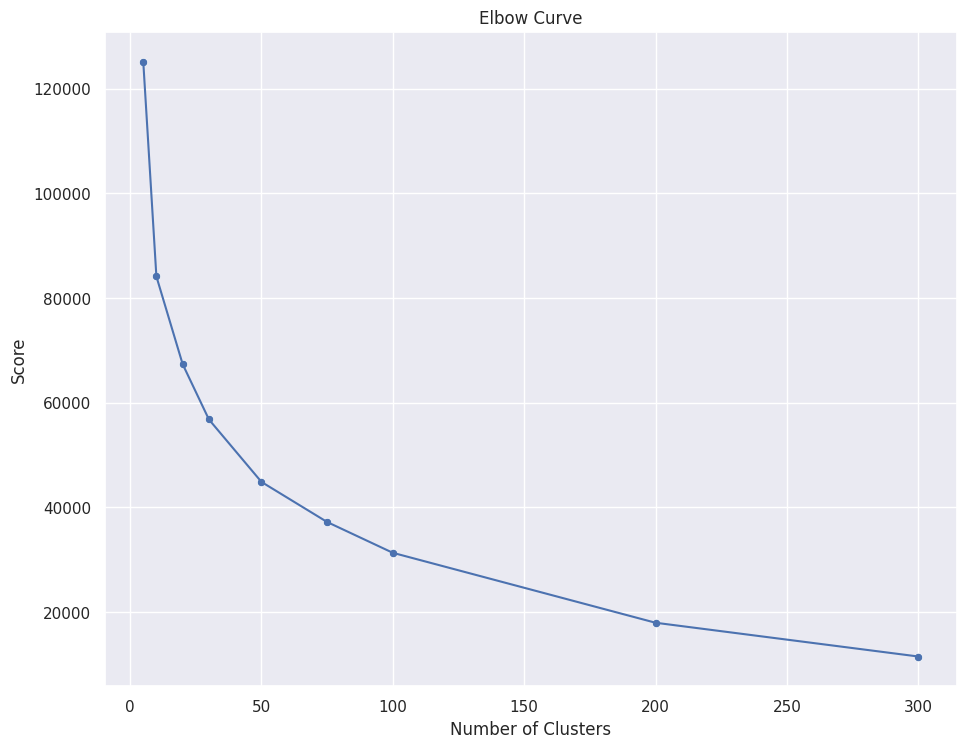

In [166]:
fig, ax = plt.subplots(figsize=(11, 8.5))
plt.title('Elbow Curve')
sns.lineplot(x="Number of Clusters",y="Score",data=df_elbow)
sns.scatterplot(x="Number of Clusters",y="Score",data=df_elbow)
plt.show()

Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

Este punto descrito arriba, visualmente sería cerca entre 50 y 75 clusters, donde podemos ver que las pendientes empiezan a estabilizarse bastante.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset Iris.



In [167]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [168]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



Veamos el dataset si requiere ser trabajado antes de aplicar el método deseado.

In [169]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  wine_

Vemos que todas las variables son numéricas, luego podemos aplicar los métodos aplicados anteriormente.

In [170]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [171]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA())

pc = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13']
X=wine.drop(columns='wine_class')
pca_pipe.fit(X)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

# Se combierte el array a dataframe para añadir nombres a los ejes.
df_pca=pd.DataFrame(
    data    = modelo_pca.components_,
    columns = X.columns,
    index   = pc
)

Con estas componentes, podemos ahora calcular la varianza explicada de cada variable. Visualizemos esto con un heatmap.

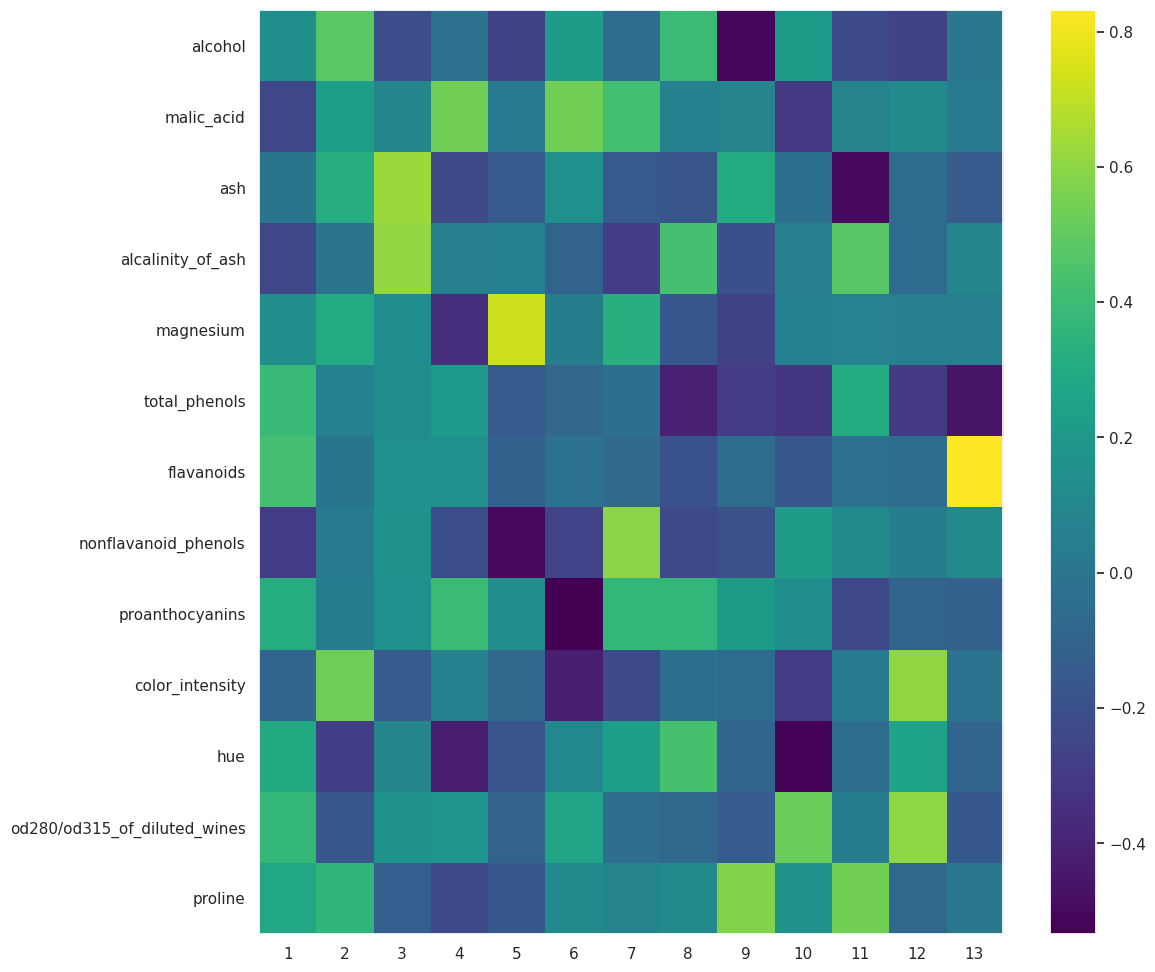

In [172]:
# Heatmap componentes
# ==============================================================================
plt.figure(figsize=(12,12))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(X.columns)), X.columns)
plt.xticks(range(len(X.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

Así, podemos calcular la proporción de la varianza explicada de cada componente con respecto al total y a la varianza acumulada.

Text(0.5, 1.0, 'Porcentaje de varianza explicada por cada componente')

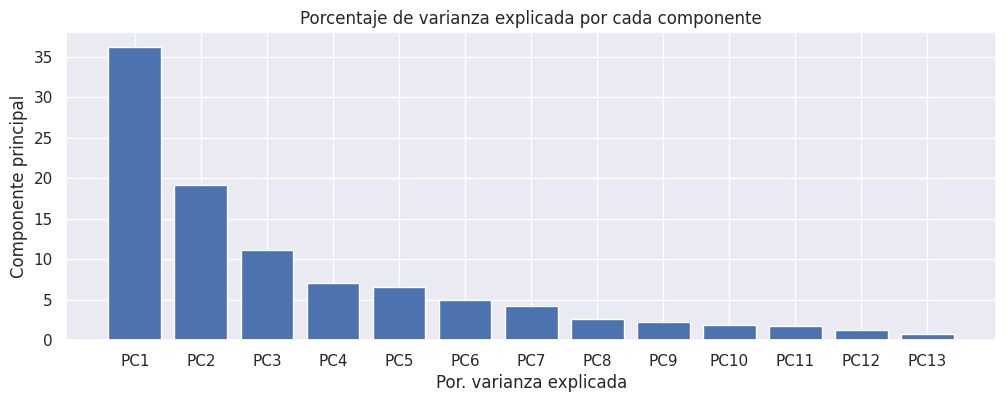

In [173]:
# graficar varianza por componente
percent_variance = np.round(modelo_pca.explained_variance_ratio_* 100, decimals =2)

plt.figure(figsize=(12,4))
plt.bar(x=range(1,14), height=percent_variance, tick_label=pc)
plt.xticks(np.arange(modelo_pca.n_components_) + 1)

plt.ylabel('Componente principal')
plt.xlabel('Por. varianza explicada')
plt.title('Porcentaje de varianza explicada por cada componente')

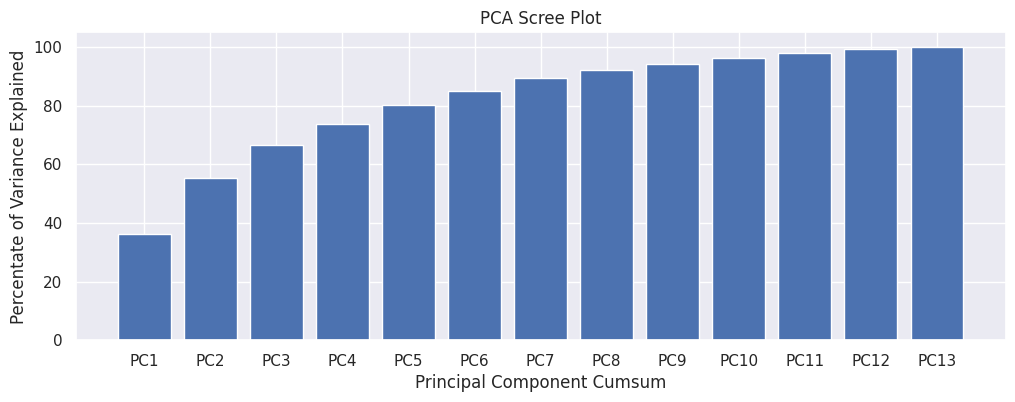

In [174]:
# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)

plt.figure(figsize=(12,4))
plt.bar(x= range(1,14), height=percent_variance_cum, tick_label=pc)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()

Podemos ver que las primeras 8 columnas explican un poco sobre el 90% de la varianza observada, y las 9 componentes pueden explicar muy cerca del 95% de la varianza observada. Luego, para la pregunta pedida, basta considerar las primeras 8 componentes principales para capturar entre el 90-95% de la información, reduciendo en 5 la dimensionalidad de los datos originales. Calculemos los loadings, simplemente multiplicando cada componente por su varianza explicada propia.

In [175]:
df_loadings=df_pca.T*percent_variance/100
df_loadings


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
alcohol,0.052247,0.092909,-0.023061,-0.001262,-0.017428,0.010549,-0.002391,0.010617,-0.011291,0.004084,-0.003931,-0.003462,0.000120
malic_acid,-0.088758,0.043209,0.009898,0.037958,0.002310,0.026519,0.017830,0.001764,0.001671,-0.005965,0.001331,0.001582,0.000208
ash,-0.000742,0.060717,0.069636,-0.015142,-0.009382,0.007631,-0.006325,-0.004563,0.006831,-0.000524,-0.008677,-0.000645,-0.001130
alcalinity_of_ash,-0.086634,-0.002034,0.068063,0.004303,0.004336,-0.004981,-0.012167,0.011470,-0.004450,0.001019,0.008340,-0.000725,0.000733
magnesium,0.051401,0.057560,0.014540,-0.024872,0.047694,0.001884,0.013690,-0.004190,-0.006025,0.001310,0.001240,0.000809,0.000454
total_phenols,0.142867,0.012494,0.016255,0.014003,-0.009795,-0.004156,-0.001184,-0.010879,-0.006350,-0.006179,0.005296,-0.003950,-0.003711
flavanoids,0.153102,-0.000645,0.016756,0.010767,-0.007152,-0.000935,-0.002573,-0.005018,-0.001101,-0.003149,-0.000447,-0.000558,0.006658
nonflavanoid_phenols,-0.108069,0.005529,0.018945,-0.014373,-0.032846,-0.012775,0.025247,-0.006252,-0.004340,0.004160,0.002034,0.000551,0.000912
proanthocyanins,0.113461,0.007550,0.016619,0.028213,0.008978,-0.026369,0.015779,0.009868,0.004643,0.002590,-0.004130,-0.001242,-0.000935
color_intensity,-0.032079,0.101812,-0.015268,0.004661,-0.005014,-0.020681,-0.009655,-0.000906,-0.001248,-0.005612,0.000554,0.007855,-0.000096


Podemos ver que la primera componente principal incluye valores elevados de las variables `total_phenols`, `flavanoids`, `proanthocyanins`, `hue`, `od280/od315_of_diluted_wines` y `proline`, indicando que estas son las variables con mayor influencia en las nuevas dimensiones.

También, tiene valores bajos en las variables `malic_acid`,`alcalinity_of_ash` y `nonflavanoid_phenols`, que indican bastante influencia pero detrimental en las dimensiones nuevas.

Las variables no mencionadas en lo anterior, `alcohol`, `ash`, `magnesium` y `color_intensity` tienen magnitud bastante pequeña en la primera componente, pero tienen más influencia en la segunda y tercera componente principal, indicando que no poseen tanta influencia en la clasificación de vino como las variables anteriores.

Visualicemos los clusters para las primeras dos componentes principales.

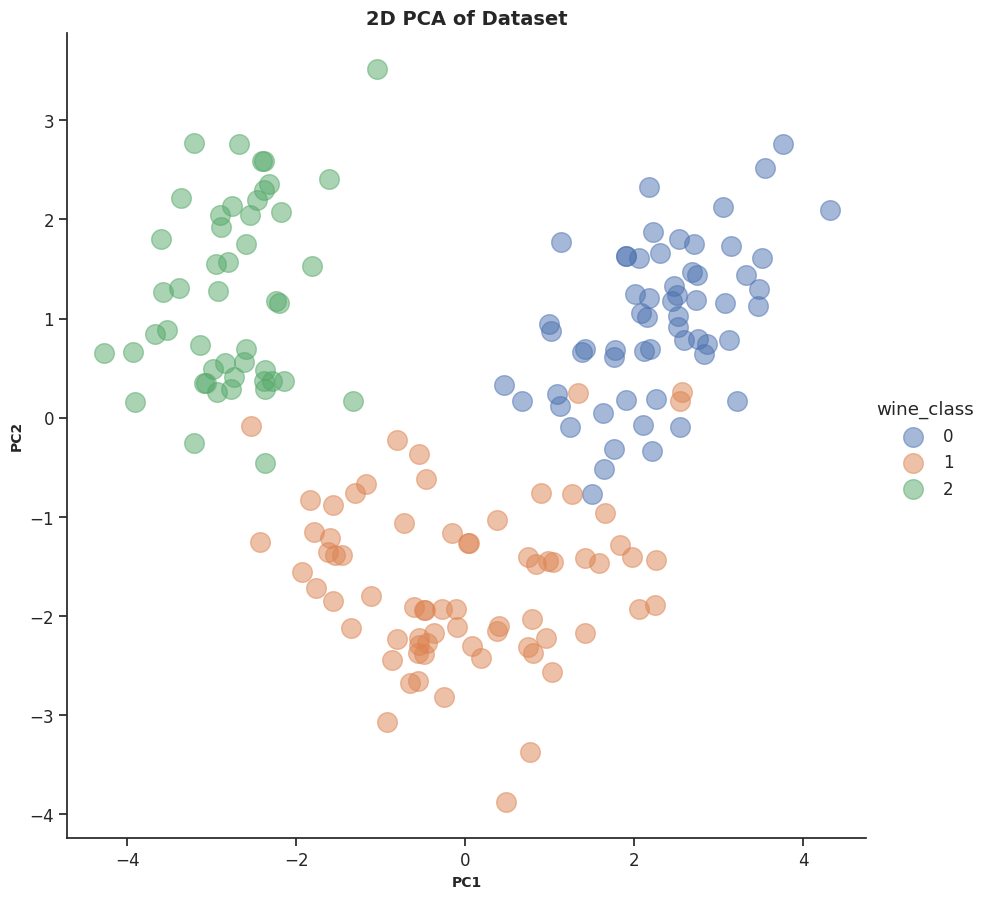

In [176]:
X = wine.drop(columns='wine_class')
X_scaled=StandardScaler().fit_transform(X)
y = wine['wine_class']

# PCA con 2 componentes

embedding = PCA(n_components=2)
X_PC2 = embedding.fit_transform(X_scaled)

df_pca2=pd.DataFrame(X_PC2,columns = ['PC1','PC2'])
df_pca2['wine_class'] = y

# Plot Digits PCA
# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot(x='PC1',
           y='PC2',
           data=df_pca2,
           fit_reg=False,
           legend=True,
           height=9,
           hue='wine_class',
           scatter_kws={"s":200, "alpha":0.5})

plt.title('2D PCA of Dataset', weight='bold').set_fontsize('14')
plt.xlabel('PC1', weight='bold').set_fontsize('10')
plt.ylabel('PC2', weight='bold').set_fontsize('10')

Se puede ver que separa relativamente bien en clusters las clases de vino. Ahora, para las 3 componentes principales.

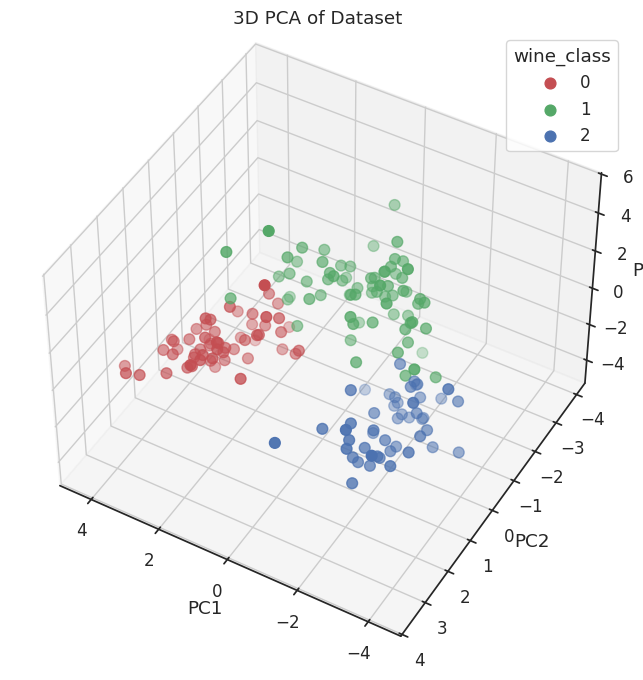

In [177]:
# PCA con 2 componentes

embedding = PCA(n_components=3)
X_PC3 = embedding.fit_transform(X_scaled)

df_pca3 = pd.DataFrame(X_PC3,columns = ['PC1','PC2','PC3'])
df_pca3['wine_class'] = y

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each target group with a different color
colors = ['r', 'g', 'b'] # Define colors for each target class
for target_name, color in zip(wine['wine_class'].unique(), colors):
    indices_to_plot = df_pca3['wine_class'] == target_name
    ax.scatter(df_pca3.loc[indices_to_plot, 'PC1'],
               df_pca3.loc[indices_to_plot, 'PC2'],
               df_pca3.loc[indices_to_plot, 'PC3'],
               c=color,
               s=60,
               label=target_name)

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA of Dataset')
ax.view_init(elev=45, azim=120)
ax.legend(title='wine_class')
plt.show()

Podemos ver los clusters un poco mas definidos pero sin mucha diferencia al grafico 2D.



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



Apliquemos t-SNE en 2 dimensiones y probemos distintas configuraciones de hiperparámetros. Visualicemos altiro estos gráficos y veamos como resultan.

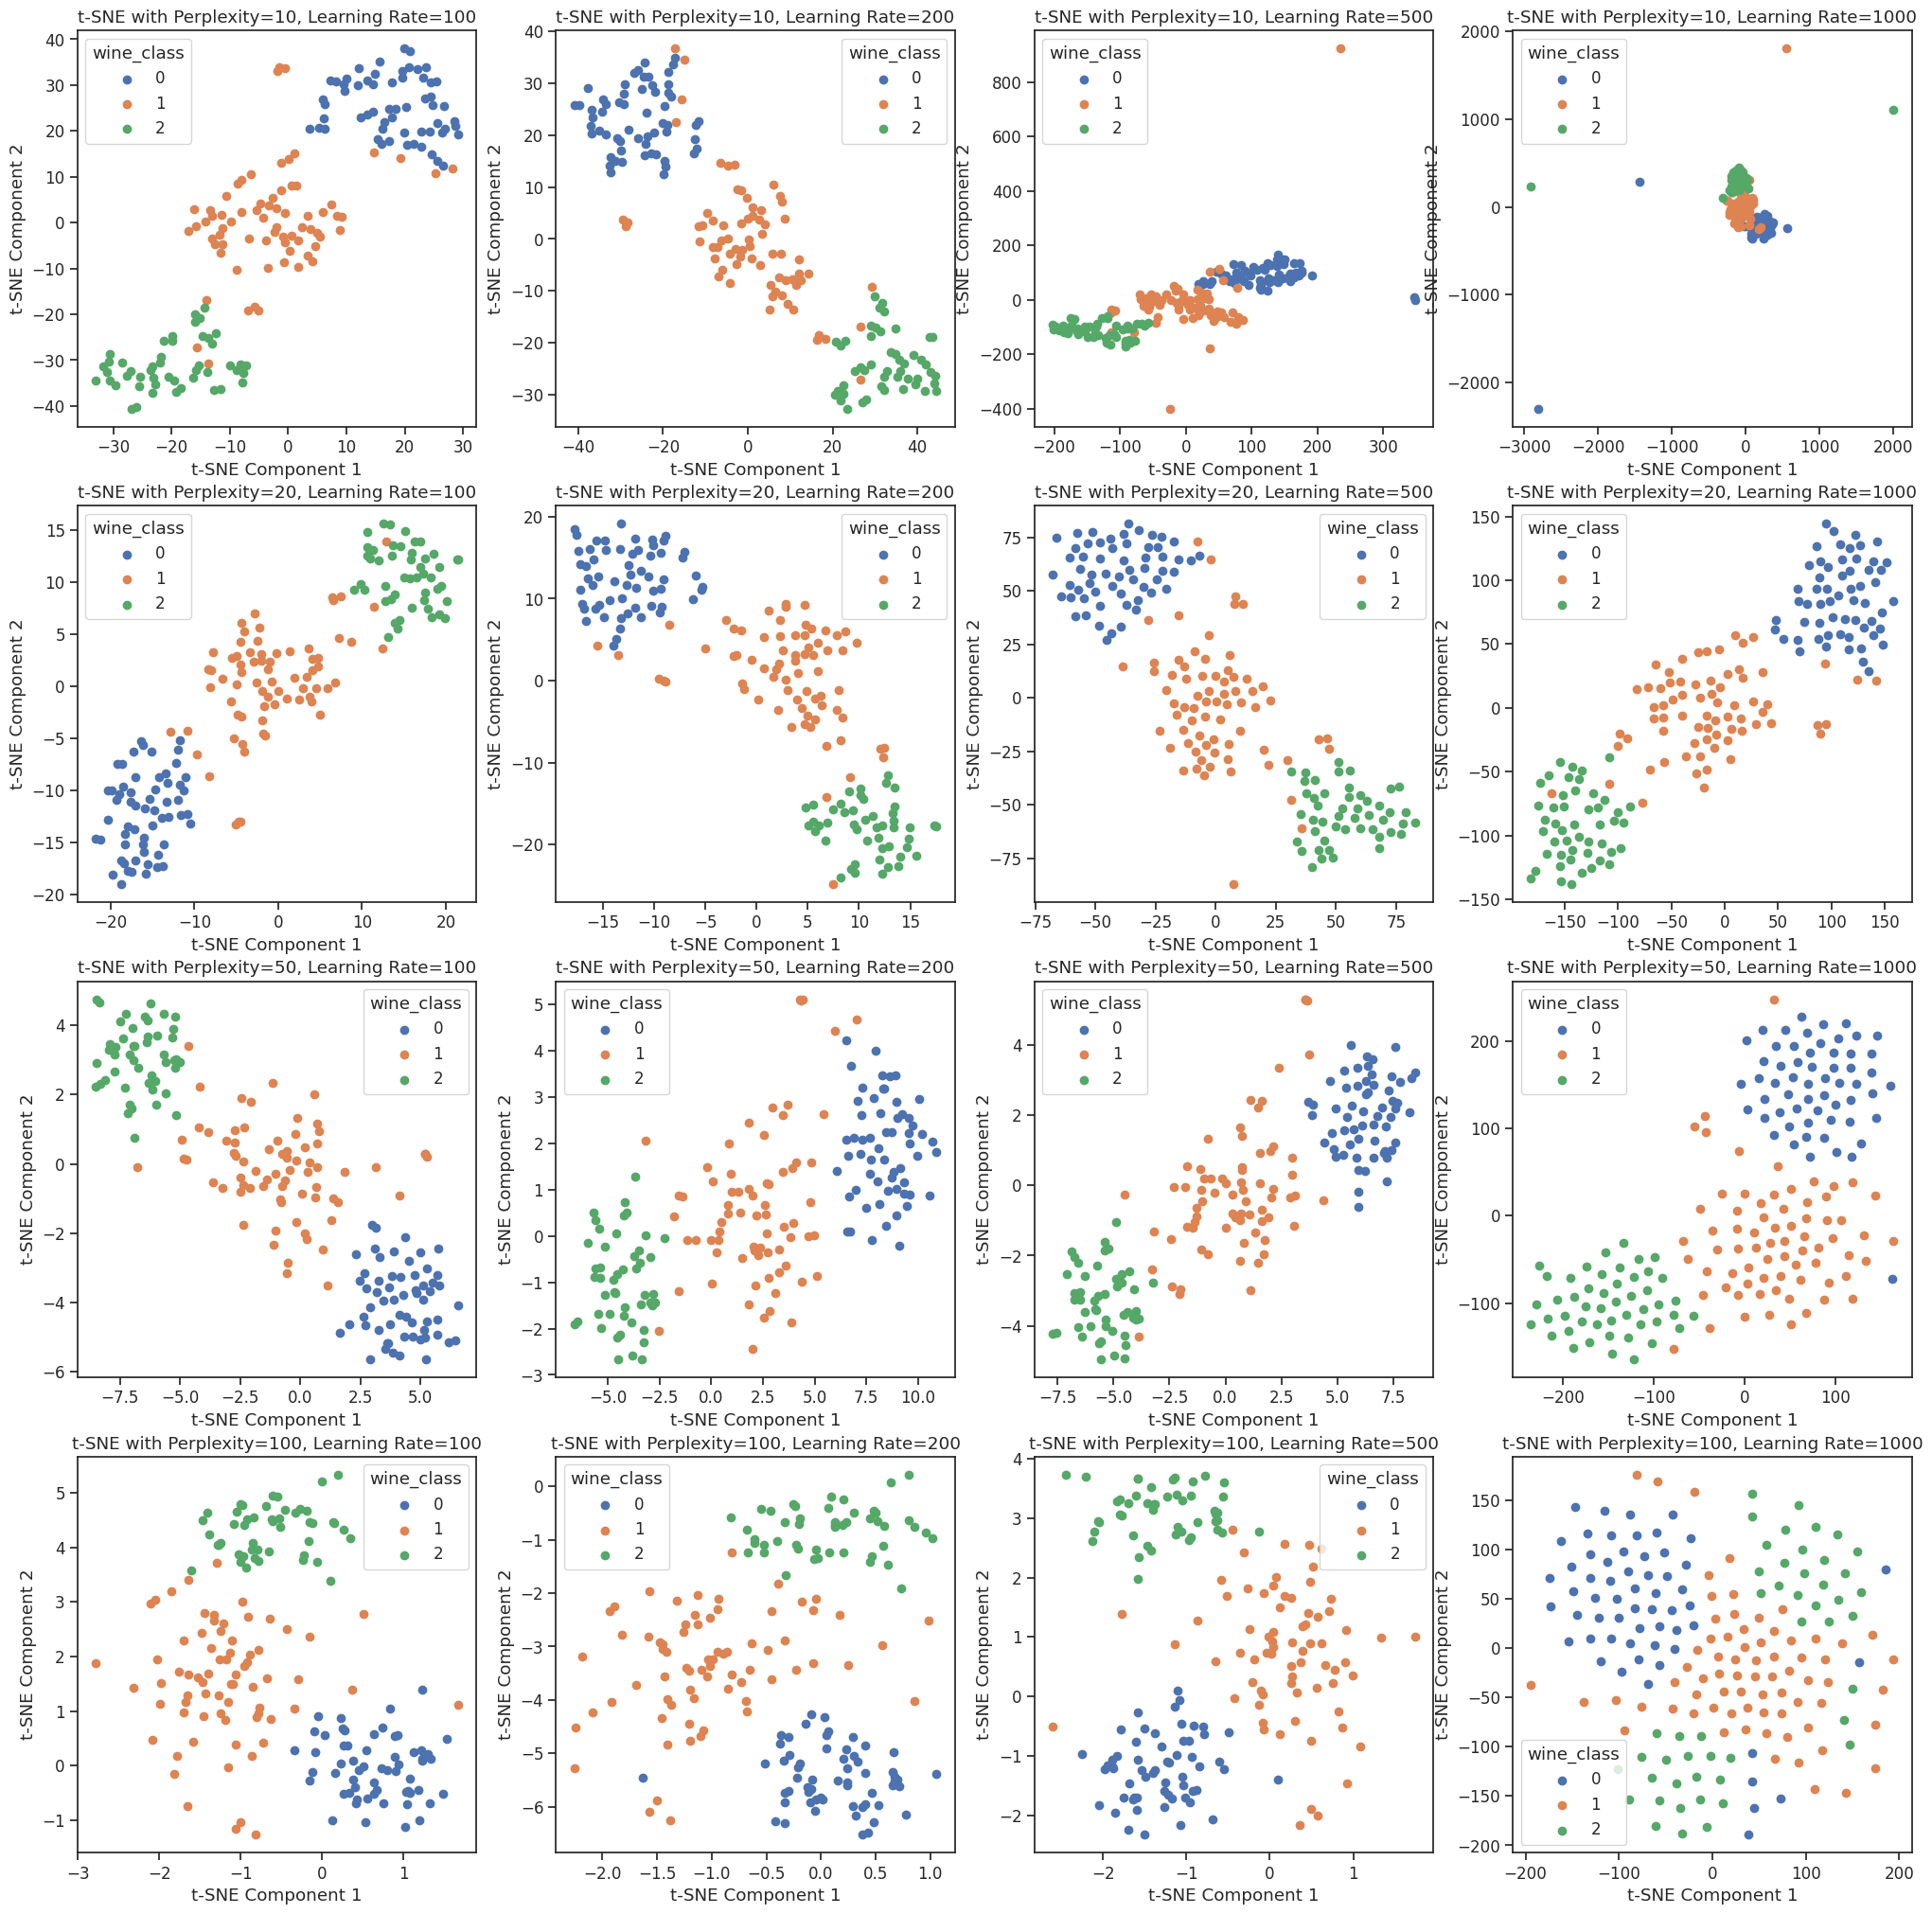

In [178]:
perplexities = [10, 20, 50, 100]
learning_rates = [100, 200, 500, 1000]

fig, axs = plt.subplots(len(perplexities), len(learning_rates), figsize=(25,25))

for i in range(len(perplexities)):
    for j in range(len(learning_rates)):
        tsne = TSNE(n_components=2, perplexity=perplexities[i], learning_rate=learning_rates[j], random_state=1)
        df_tsne = pd.DataFrame(data=tsne.fit_transform(X_scaled),columns=['t-SNE1','t-SNE2'])
        df_tsne['wine_class']=y

        for wine_class in range(3):
          cond = (df_tsne['wine_class'] == wine_class)
          axs[i, j].scatter(df_tsne[cond]['t-SNE1'], df_tsne[cond]['t-SNE2'], label=wine_class)

        axs[i, j].set_title(f't-SNE with Perplexity={perplexities[i]}, Learning Rate={learning_rates[j]}')
        axs[i, j].set_xlabel('t-SNE Component 1')
        axs[i, j].set_ylabel('t-SNE Component 2')
        axs[i, j].legend(title='wine_class')


Podemos ver que, visualmente la mejor separación en clusters ocurre cuando `perplexity=50` y `learning_rate=100`. Aquí los clusters para los vinos de clase 0 y 2 están muy bien formados, y los vinos de clase 1 solapan bastante poco con ambos clusters. Luego, t-SNE captura ciertos comportamientos no lineales del dataset y logra separar el dataset en las clases de vino bastante bien, pues para las dos componentes mostradas muestra mejor separación que con PCA.

Podemos ver además que, a medida que se aumenta `perplexity`, los puntos en este gráfico tienden a apelotonarse y desplazarse en conjunto, preservando localmente su estructura en general. Además, a medida que se aumenta `learning_rate` tiende a querer uniformizar la distancia entre los datos, tendiendo a alejar los datos entre sí. Esto no es cierto específicamente para el caso de perplexity baja y learning rate alto, pues hay un par de datos outliers que se escapan mucho en magnitud de la mayoria de los datos.



### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



- **Ventajas:** Una ventaja grande de PCA es que, al ser lineal, cada característica del dato se le puede dar un peso en específico, y es posible explicar que componentes del dato son más importantes para poder distinguir el fenómeno. Además, permite entender componentes irrelevantes del dataset para la clasificación que encuentra, permitiendo obtener resultados muy similares reduciendo la dimensionalidad del dataset. Por otro lado, t-SNE logra separar de mejor forma estos datos y forma clusters mejor definidos que los resultados obtenidos con PCA. Además, es posible ajustar los hiperparámetros de este método obteniendo distintos tipos de agrupamiento de los datos, que pueden resultar útiles dependiendo del tipo de pregunta que se quiera responder.

- **Limitaciones:** Una limitación de PCA es que, si se tienen muchas componentes importantes, es dificil visualizar el agrupamiento de los datos en un gráfico, pues si las primeras dos o tres componentes son insuficientes para distinguir claramente el dataset entonces no se podría visualizar el comportamiento de manera clara. Por otro lado, una limitación del t-SNE es que, al ser un modelo no lineal, las componentes que encuentra no tienen mucha interpretación o representabilidad en el mundo real, y es más dificil responder preguntas sobre que variables son importantes para la clasificación.

- **Preferencias de modelos:** En mi opinión, PCA es más recomendable de usar cuando uno quiere responder preguntas cualitativas del comportamiento de las variables con la clasificación que se tiene. t-SNE es más recomendable cuando estas preguntas no son de mucho interés, y se quiere solamente encontrar de las mejores separaciones del dataset posible.

- **Sobre reducción de dimensionalidad:** La reducción de dimensionalidad de los datos es crucial para poder entender fenómenos complicados, mucho más cuando se puede mostrar que gran parte de las dimensiones pueden ser irrelevantes para la pregunta que se quiere responder. Esto permite trabajar con un dataset mas pequeño, y obtener resultados muy cercanos a los que uno obtendría en trabajar el dataset original. Hay muchas ventajas en esto, en aspectos de memoria, de rendimiento y de comprendimiento de la clasificación que se intenta hacer.

